## Plot performance of models against underlying price

In [54]:
import sys
sys.path += ['../']

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lag_functions import shift_timeseries_by_lags
from lstm_functions import LSTM
from functions import plot_performace

plt.rcParams["figure.figsize"] = (8, 7)
plt.rcParams['figure.dpi'] = 300

### BTC Movement

In [2]:
coin = 'btc'

In [3]:
price_data = pd.read_parquet(f'../../2_data_processing/numeric_data/{coin}_price_data.parquet.gzip').iloc[:,0]

numeric_data = pd.read_parquet(f'../../2_data_processing/numeric_data/{coin}_numeric_stationary_data.parquet.gzip')
nlp_data = pd.read_parquet(f'../../3_nlp_models/4_processing/{coin}_stationary_text_data.parquet.gzip')
targets = pd.read_parquet(f'../../2_data_processing/numeric_data/{coin}_targets.parquet.gzip')

if coin == 'btc':
    data = (pd.concat([numeric_data, nlp_data], axis=1)
            .loc[1314662400:1678752000])
elif coin == 'eth':
    data = (pd.concat([numeric_data, nlp_data], axis=1)
            .loc[1445472000:1678838400])
data = (data.fillna(method='ffill')
            .fillna(0)
            .replace([np.inf, -np.inf], 0))

In [72]:
with open(f'../../4_eda/{coin}_lstm_causality/{coin}_price_log_difference_causality.txt') as f:
    price_log_difference_vars = f.read().splitlines()
X = data[price_log_difference_vars]
columns_to_keep = [
    col for col in X.columns if 'finetuned' not in col
]
X = X[columns_to_keep]
X = shift_timeseries_by_lags(X, np.arange(0, 14))
input_shape = (len(X.columns.levels[1]), len(X.columns.levels[0]))

X_train = X
X_test = X.tail(800).head(300)
targets_train = targets
targets_test = targets.tail(800).head(300)
price_data_test = price_data.tail(800).head(300)

y_train = (targets_train[f'{coin}_price_log_difference'] > 0) * 1
y_test = (targets_test[f'{coin}_price_log_difference'] > 0) * 1

model_args = {
    'lstm_layer_sizes': [240],
    'dense_layer_sizes': [136, 141, 60],
    'activation': 'tanh',
    'dropout': 0.261083994,
    'optimizer': 'Adam',
    'learning_rate': 0.001122192,
    'scaling': 'MinMaxScaler',
}
training_args = {
    'epochs': 90,
    'batch_size': 64,
    'verbosity': 0,
}

model = LSTM(input_shape, **model_args)
model.fit(X_train, y_train, **training_args)
y_pred = model.predict_proba(X_test)

No GPUs available.
10/10 [==============================] - 0s 3ms/step


In [73]:
y_pred_d = (y_pred >= 0.5) * 1
y_pred_d = pd.Series(y_pred_d, index=X_test.index)

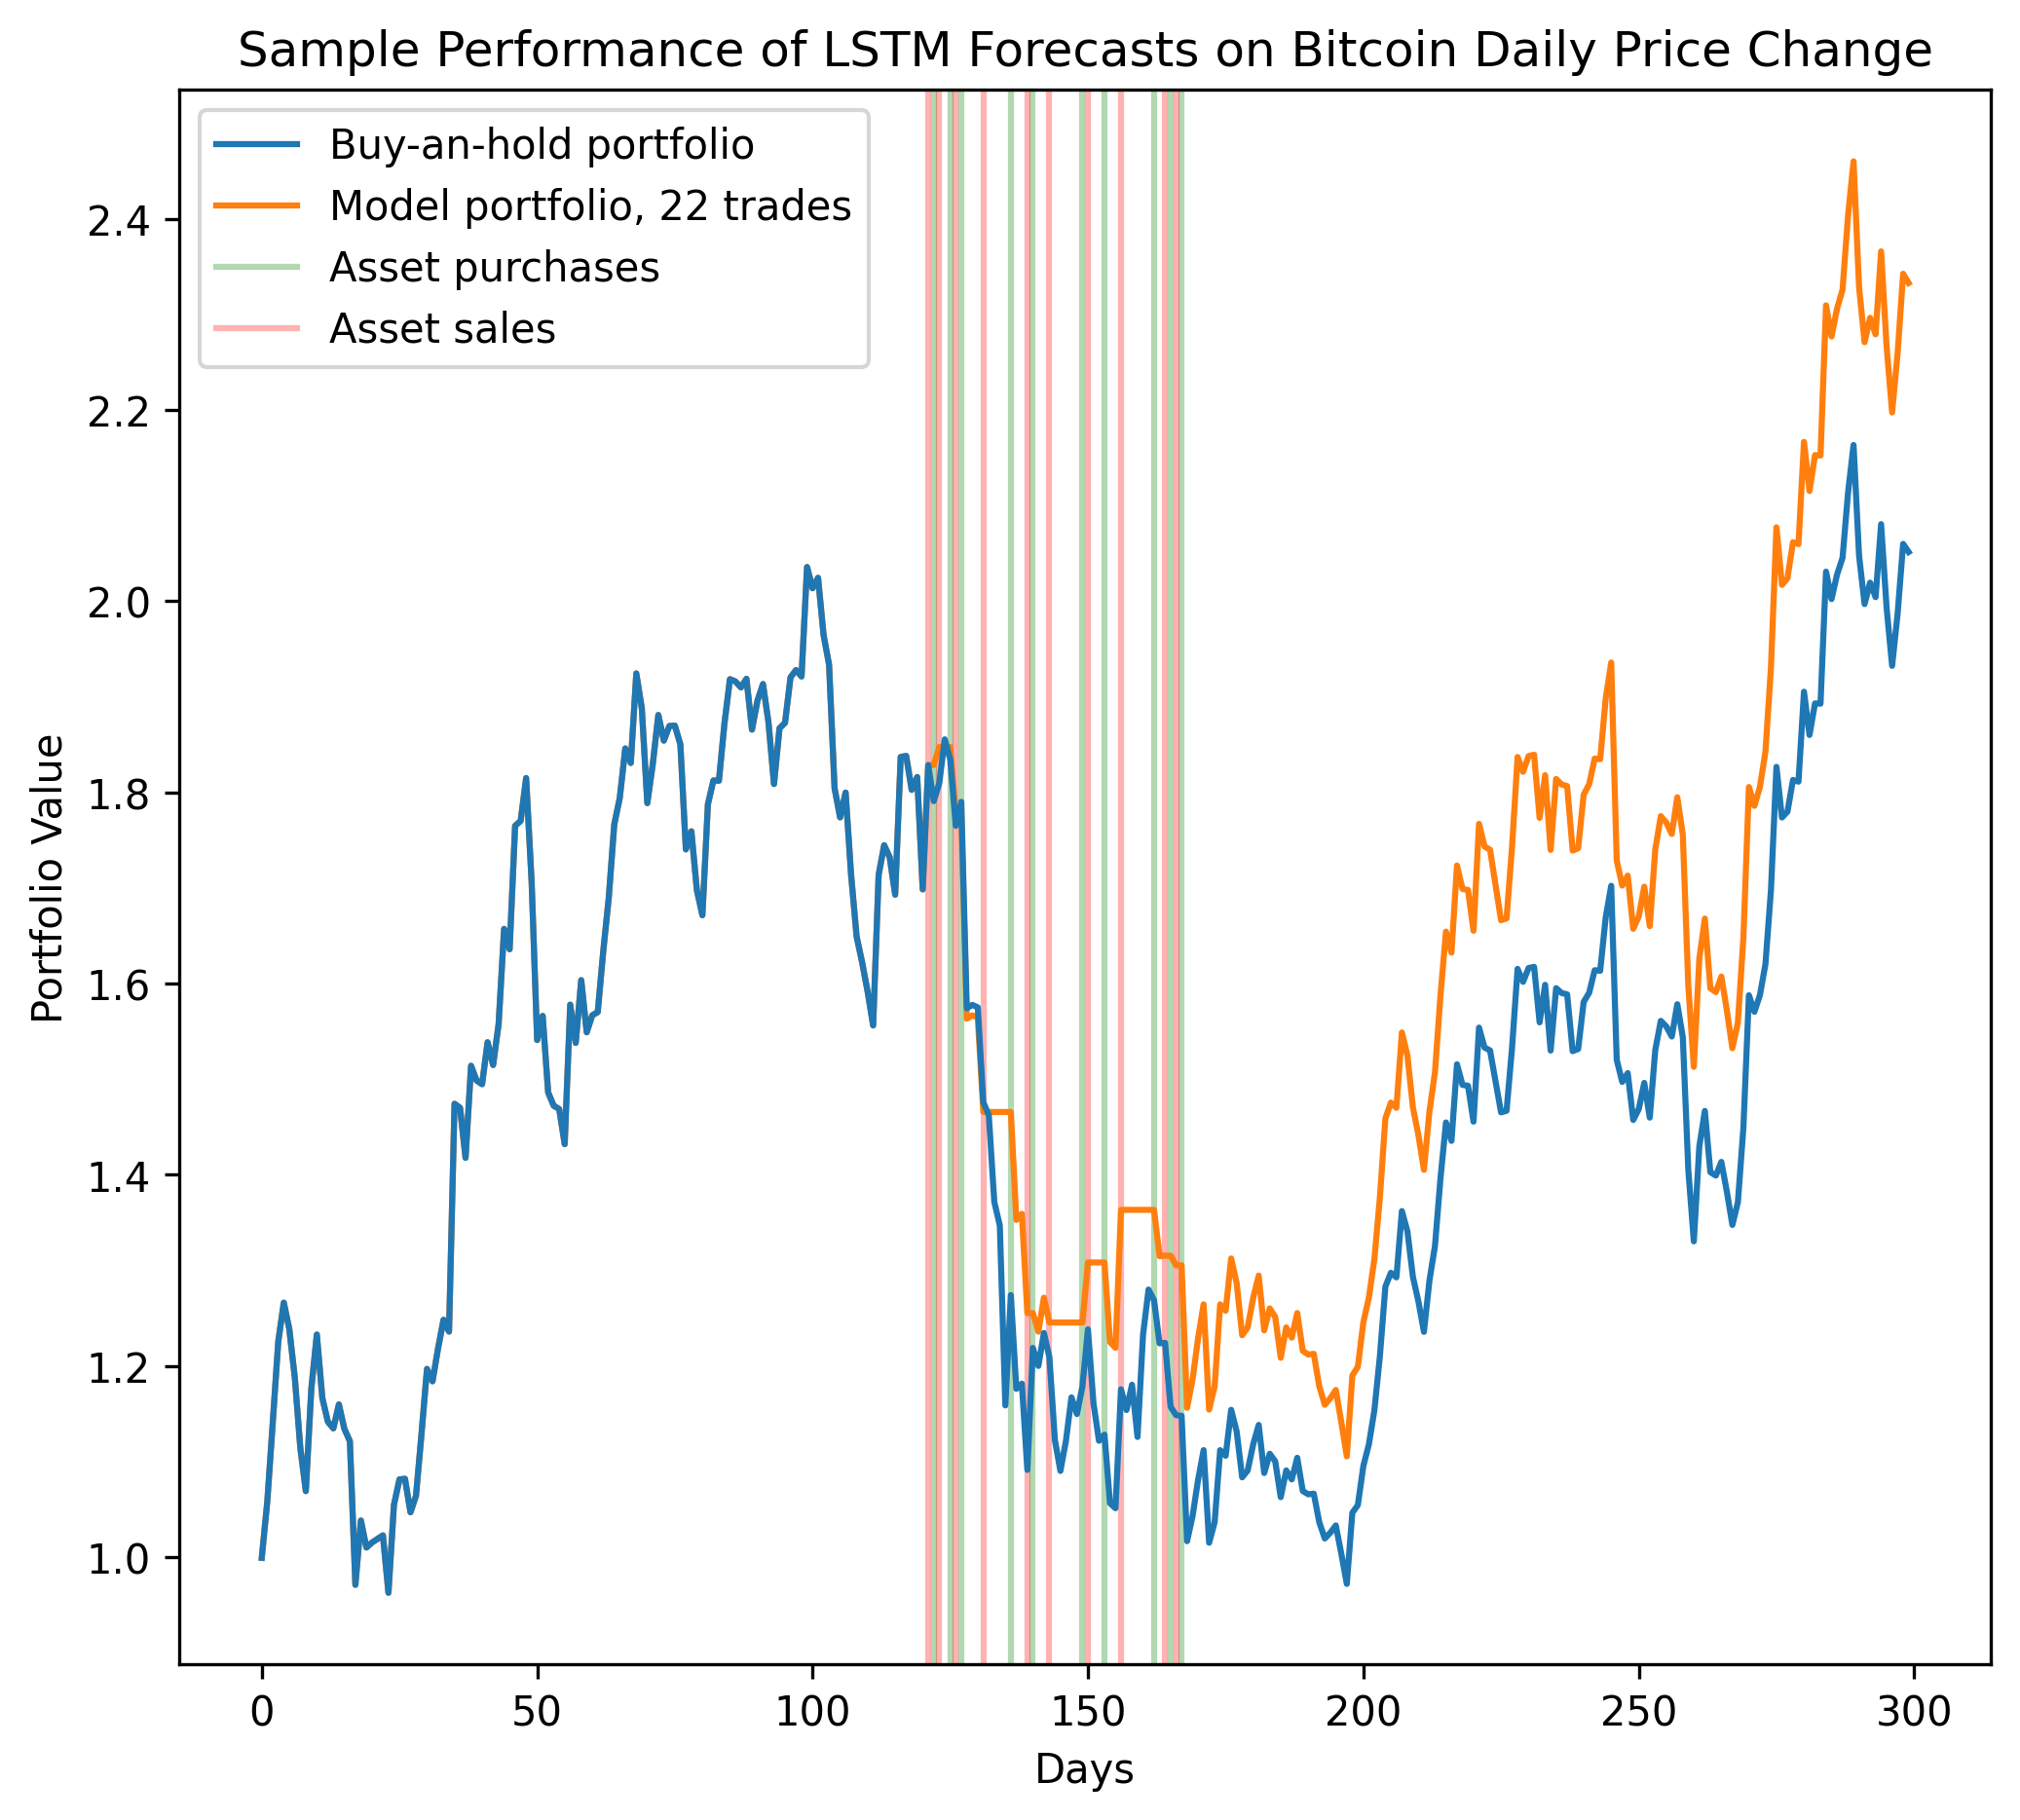

In [74]:
ax = plot_performace(price_data_test, y_pred_d, 'movement')
plt.title('Sample Performance of LSTM Forecasts on Bitcoin Daily Price Change')
# loc = plticker.MultipleLocator(base=0.5) # this locator puts ticks at regular intervals
# ax.yaxis.set_major_locator(loc)
plt.show()

### BTC 7d extrema

In [6]:
timeframe = 7

with open(f'../../4_eda/{coin}_lstm_causality/{coin}_price_min_{timeframe}d_causality.txt') as f:
    price_min_vars = f.read().splitlines()
with open(f'../../4_eda/{coin}_lstm_causality/{coin}_price_max_{timeframe}d_causality.txt') as f:
    price_max_vars = f.read().splitlines()
X_min = data[price_min_vars]
X_max = data[price_max_vars]
columns_to_keep = [
    col for col in X_min.columns if 'finetuned' not in col
]
X_min = X_min[columns_to_keep]
columns_to_keep = [
    col for col in X_max.columns if 'finetuned' not in col
]
X_max = X_max[columns_to_keep]

X_min = shift_timeseries_by_lags(X_min, np.arange(0, 14))
X_max = shift_timeseries_by_lags(X_max, np.arange(0, 14))
input_shape_min = (len(X_min.columns.levels[1]), len(X_min.columns.levels[0]))
input_shape_max = (len(X_max.columns.levels[1]), len(X_max.columns.levels[0]))

X_min_train = X_min
X_min_test = X_min.tail(800).head(300)
X_max_train = X_max
X_max_test = X_max.tail(800).head(300)
targets_train = targets
targets_test = targets.tail(800).head(300)
price_data_test = price_data.tail(800).head(300)

y_min_train = targets_train[f'{coin}_price_min_{timeframe}d']
y_max_train = targets_train[f'{coin}_price_max_{timeframe}d']
y_min_test = targets_test[f'{coin}_price_min_{timeframe}d']
y_min_test = targets_test[f'{coin}_price_max_{timeframe}d']

model_args = {
    'lstm_layer_sizes': [99, 97, 289],
    'dense_layer_sizes': [],
    'activation': 'relu',
    'dropout': 0.15589582,
    'optimizer': 'Adam',
    'learning_rate': 0.00017695,
    'scaling': None,
}
training_args = {
    'epochs': 76,
    'batch_size': 128,
    'verbosity': 0,
}

min_model = LSTM(input_shape_min, **model_args)
min_model.fit(X_min_train, y_min_train, **training_args)
y_min_pred = min_model.predict_proba(X_min_test)

max_model = LSTM(input_shape_max, **model_args)
max_model.fit(X_max_train, y_max_train, **training_args)
y_max_pred = max_model.predict_proba(X_max_test)

No GPUs available.
10/10 [==============================] - 0s 11ms/step
No GPUs available.
10/10 [==============================] - 0s 14ms/step


In [89]:
y_min_pred_d = (y_min_pred >= 0.08) * 1
y_min_pred_d = pd.Series(y_min_pred_d, index=X_min_test.index)
y_max_pred_d = (y_max_pred >= 0.08) * 1
y_max_pred_d = pd.Series(y_max_pred_d, index=X_max_test.index)

y_pred = pd.DataFrame({
    'min': y_min_pred_d,
    'max': y_max_pred_d,
})

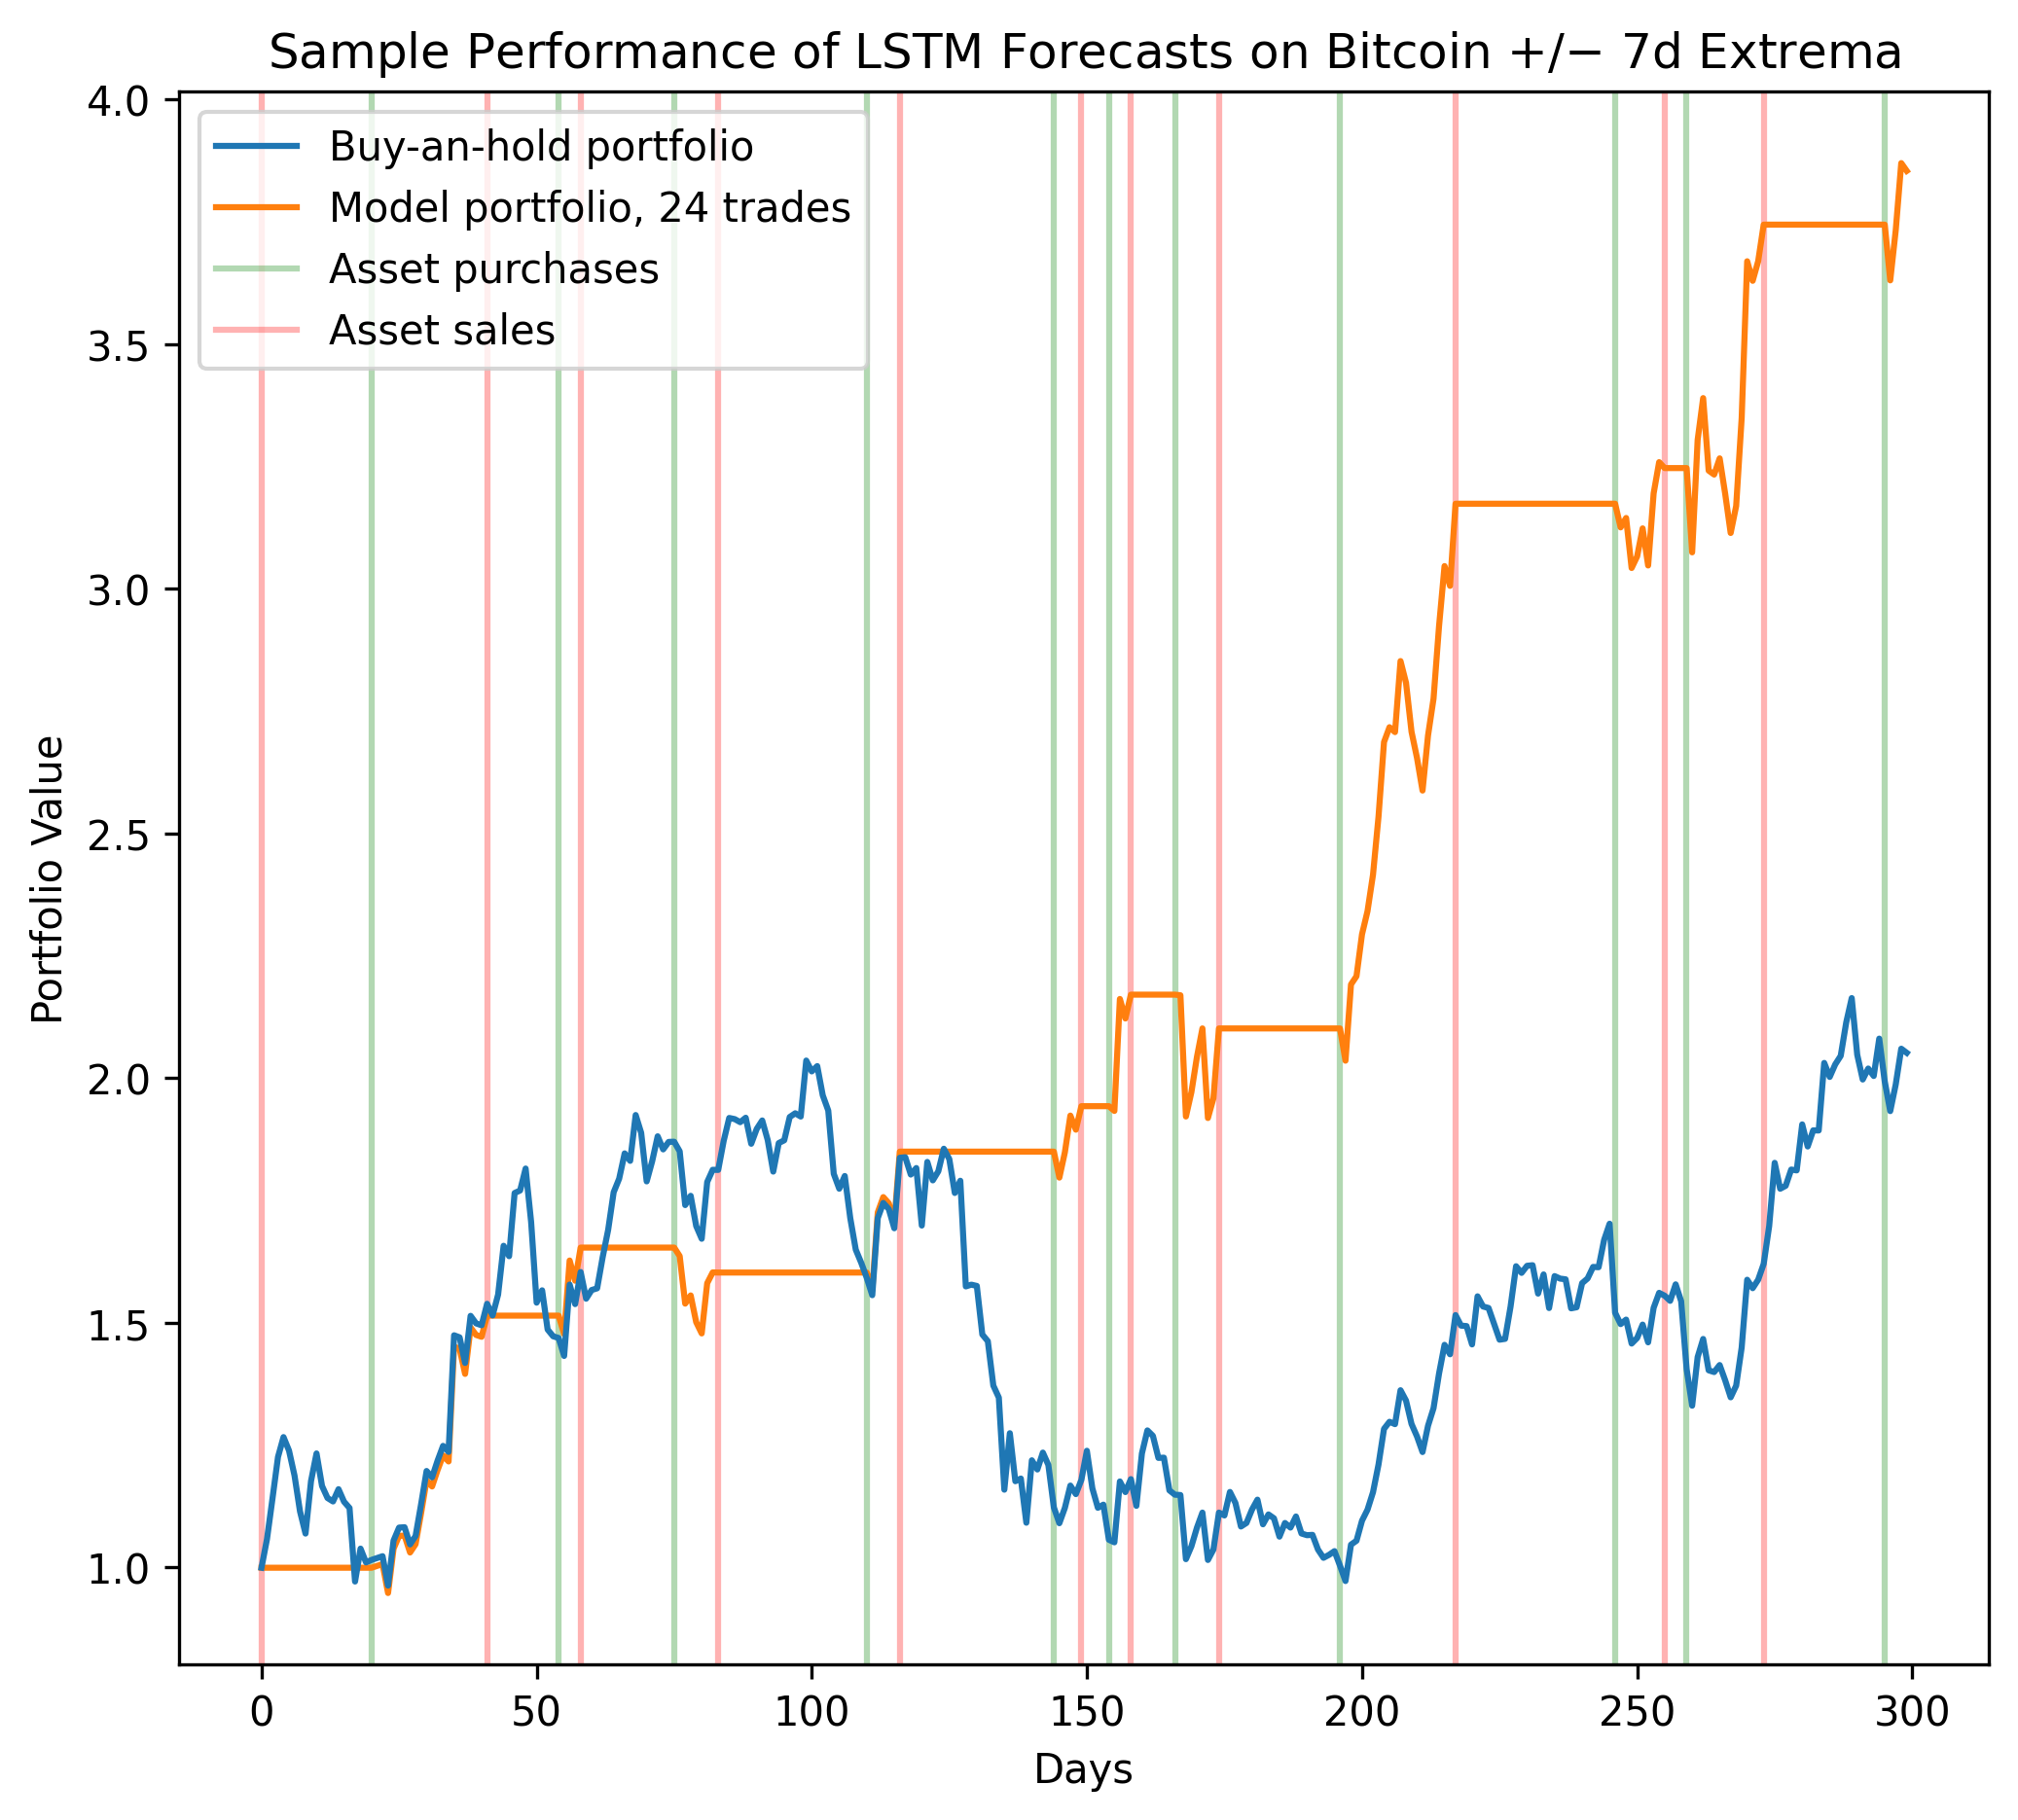

In [90]:
ax = plot_performace(price_data_test, y_pred, 'extrema')
plt.title(f'Sample Performance of LSTM Forecasts on Bitcoin +/$-$ {timeframe}d Extrema')
# loc = plticker.MultipleLocator(base=0.5) # this locator puts ticks at regular intervals
# ax.yaxis.set_major_locator(loc)
plt.show()